In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/pro2024

/content/drive/MyDrive/pro2024


In [ ]:
ls

data.zip  multi_object_tracking.zip  viewer.zip


In [ ]:
# !unzip -q viewer.zip

In [ ]:
# !unzip -q data.zip

In [ ]:
# !unzip -q multi_object_tracking.zip

In [ ]:
!mv data multi_object_tracking/data
!mv viewer multi_object_tracking/viewer

In [ ]:
!sudo apt-get install libgl1-mesa-dev libgl1-mesa-glx  xvfb -qq

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 19.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libglx-dev:amd64.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../00-libglx-dev_1.4.0-1_amd64.deb ...
Unpacking libglx-dev:amd64 (1.4.0-1) ...
Selecting previously unselected package libgl-dev:amd64.
Preparing to unpack .../01-libgl-dev_1.4.0-1_amd64.deb ...
Unpacking libgl-dev:amd64 (1.4.0-1) ...
Selecting previously unselected package libegl-dev:amd64.
Preparing to unpack .../02-libegl-dev_1.4.0-1_amd64.deb ...
Unpacking libegl-dev:amd64 (1.4.0-1) ...
Sel

In [ ]:
!pip install git+https://github.com/Jeremy26/vedo-mot.git
!pip install ipyvtklink -q
!pip install numpy==1.23.5

  Cloning https://github.com/Jeremy26/vedo-mot.git to /tmp/pip-req-build-jnv2ccf8
  Running command git clone --filter=blob:none --quiet https://github.com/Jeremy26/vedo-mot.git /tmp/pip-req-build-jnv2ccf8
  Resolved https://github.com/Jeremy26/vedo-mot.git to commit 2bf7b78a631556e9a6b05b21c1e5c53cf4b911bf
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 MB 9.0 MB/s eta 0:00:00
  Created wheel for vedo: filename=vedo-2022.4.2-py3-none-any.whl size=3116540 sha256=51ded157d2e26f14f035befe96dd3cfec428ae059341c86503f1dc97937356a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-px6dkvza/wheels/75/37/b8/7cbdd488b55a9e7c4ae12d42b03c88e612c382f6af66dbc392
Successfully built vedo
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 73.7 MB/s eta 0:00:00
  Attempting uninstall: num

In [ ]:
exit()  #restart runtime

In [ ]:
cd /content/drive/MyDrive/pro2024

/content/drive/MyDrive/pro2024


In [ ]:
# Activate virtual display (headless display)
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

In [ ]:
import time
import tqdm
import os
import numpy as np
import argparse
from pathlib import Path
import yaml
from easydict import EasyDict
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import cv2
import shutil
from vedo import *
import re

In [ ]:
from multi_object_tracking.dataset.kitti_data_base import velo_to_cam
from multi_object_tracking.viewer.viewer import Viewer
from multi_object_tracking.viewer.utils import *
from multi_object_tracking.dataset.kitti_data_base import *

In [ ]:
class KittiDataset():
    def __init__(self,root_path,seq_id, label_path = None):
        self.seq_name = str(seq_id).zfill(4)
        self.root_path = root_path
        self.velo_path = os.path.join(self.root_path,"velodyne", self.seq_name)
        self.image_path = os.path.join(self.root_path,"image_02", self.seq_name)
        self.calib_path = os.path.join(self.root_path,"calib")
        self.label_path = label_path
        pose_path = os.path.join(self.root_path, "pose", self.seq_name,'pose.txt')
        self.poses = read_pose(pose_path)

    def __len__(self):
        return len(os.listdir(self.velo_path))

    def __getitem__(self, item):
        name = str(item).zfill(6)
        velo_path = os.path.join(self.velo_path,name+'.bin')
        image_path = os.path.join(self.image_path, name+'.png')
        calib_path = os.path.join(self.calib_path, self.seq_name+'.txt')
        label_path = os.path.join(self.label_path, self.seq_name, name+'.txt')
        pose = self.poses[item] if item in self.poses.keys() else None;

        P2,V2C = read_calib(calib_path)
        points = read_velodyne(velo_path,P2,V2C)
        image = read_image(image_path)
        objects, det_scores, det_names = self.read_detection_label(label_path)
        objects[:,3:6] = cam_to_velo(objects[:,3:6],V2C)[:,:3]

        return P2,V2C,points,image,objects,det_scores, det_names, pose

    def read_detection_label(self,label_path):
        objects_list = []
        det_scores = []
        det_names = []
        with open(label_path) as f:
            for each_ob in f.readlines():
                infos = re.split(' ', each_ob)
                if infos[0] in ['Car', 'Truck']:
                    objects_list.append(infos[8:15])
                    det_scores.append(infos[15])
                    det_names.append(infos[0])
        return np.array(objects_list, np.float32), np.array(det_scores, np.float32), det_names

In [ ]:
root="multi_object_tracking/data"
label_path = "multi_object_tracking/detectors/point_rcnn"
dataset = KittiDataset(root,seq_id=8,label_path=label_path)

In [ ]:
def visualize_scene(dataset, hand_picked_frames, detection=None, tracking=None, interactive = False, threshold=4):
    if not hand_picked_frames:
        hand_picked_frames = range(len(dataset))  #run full sequence

    if interactive==True:
        vi= Viewer(box_type="Kitti") # This is needed once for 3D Visualization

    for idx, frame in enumerate(hand_picked_frames):
        P2, V2C, points, image, labels, scores, label_names, pose = dataset[frame]
        #frame_id, pose, P2, V2C, points, image, labels, scores, label_names = dataset[frame].values()

        if interactive==False:
            vi = Viewer(box_type="Kitti") # this is needed for every frame for 2D Visualization
            vi.set_ego_car("multi_object_tracking/viewer/ego_car.3ds")

        if detection is not None:
            mask = scores > threshold
            labels = labels[mask]
            if tracking is not None:
                ids = tracking[idx]
            else:
                ids = None

            vi.add_3D_boxes(labels, ids=ids, box_info=label_names, color="red",
                            add_to_3D_scene=True, mesh_alpha = 0.4, show_corner_spheres = True,
                            corner_spheres_alpha = 1, corner_spheres_radius=0.2,
                            show_heading = True, heading_scale = 1.5, show_lines = True,
                            line_width = 3, line_alpha = 1,
                            show_ids = True, show_box_info=True, del_after_show=True,
                            add_to_2D_scene=True, caption_size=(0.09,0.09)
                            )

            vi.add_3D_cars(labels,
                        ids=ids,
                        box_info=label_names,
                        color="red",
                        mesh_alpha = 1,
                        del_after_show=True,
                        car_model_path="multi_object_tracking/viewer/car.obj",
                        caption_size = (0.1, 0.1)
                        )

        vi.add_points(points[:,0:3],
                    radius = 1,
                    color = (150,150,150),
                    scatter_filed = points[:,2],
                    alpha=1,
                    del_after_show = True,
                    add_to_3D_scene = True,
                    add_to_2D_scene = False,
                    color_map_name = "viridis")

        vi.add_image(image)
        vi.set_extrinsic_mat(V2C)
        vi.set_intrinsic_mat(P2)
        vi.show_2D()
        vi.show_3D(frame, interactive) #set interactive to False

In [ ]:
#If you need to restart the visualizer, remove the frames stored
shutil.rmtree('frames', ignore_errors=True)
shutil.rmtree("3dframes", ignore_errors= True)

### Just visualize Raw Data
hand_picked_frames = [0,1,2]
settings.default_backend = '2d_image'
settings.default_image_path_for_2d_backend = '3dframes'

visualize_scene(dataset, hand_picked_frames, detection=None, tracking=None)

The new directory 'frames' is created!
The new directory 3dframes is created!


In [ ]:
def view_images(images_to_be_shown):
  _, axs = plt.subplots(1, len(images_to_be_shown), figsize=(30, 30))

  if len(images_to_be_shown)> 1:
    axs = axs.flatten()
    for img, ax in zip(images_to_be_shown, axs):
        img_data = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
        ax.imshow(img_data)
  else:
        img_data = cv2.cvtColor(cv2.imread(images_to_be_shown[0]), cv2.COLOR_BGR2RGB)
        axs.imshow(img_data)

  plt.show()

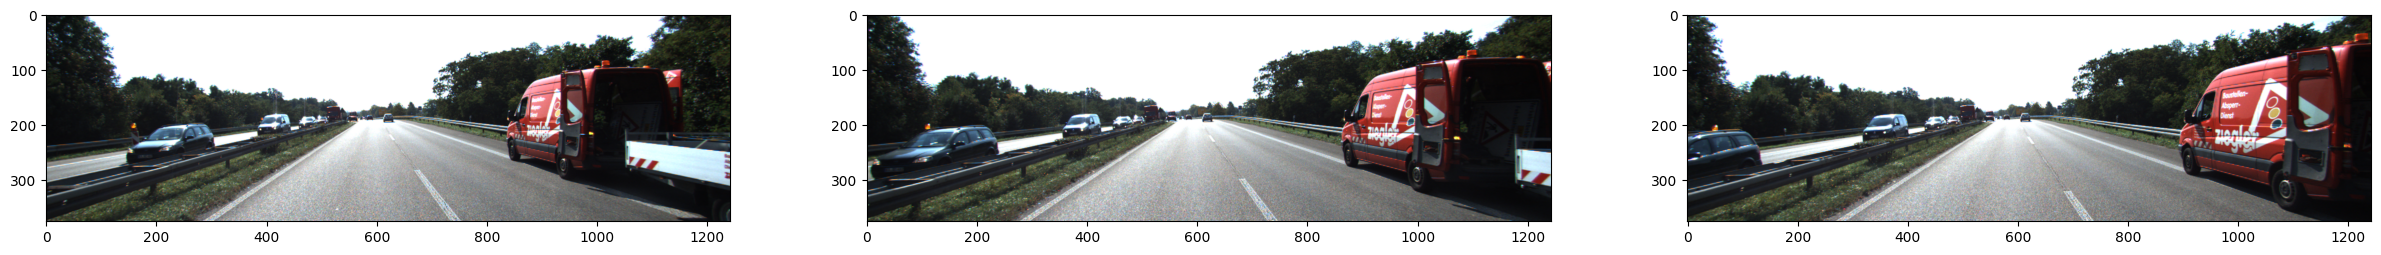

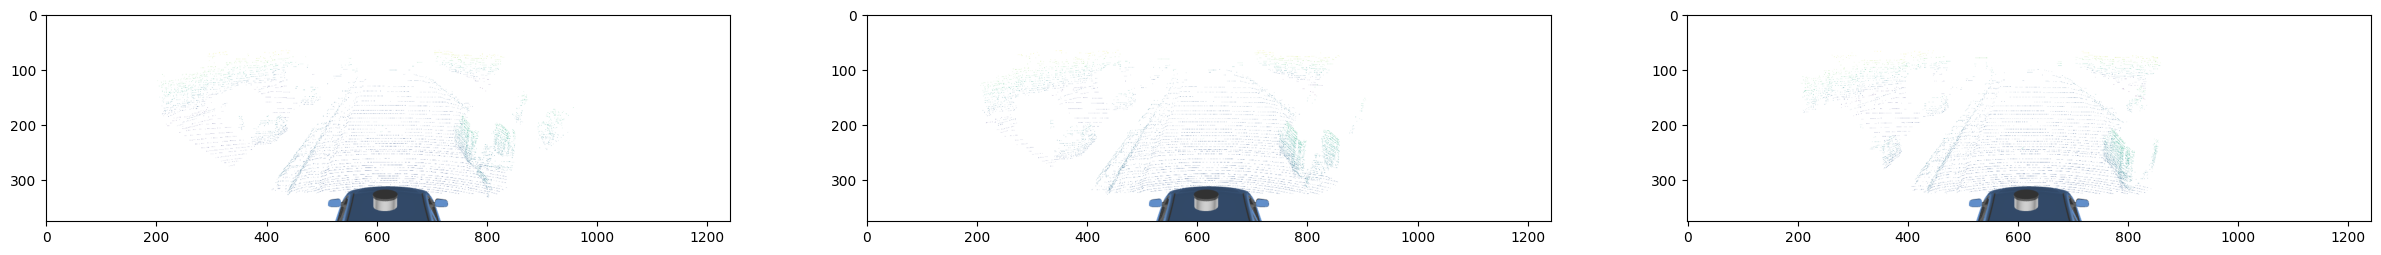

In [ ]:
images_2d = glob.glob("frames/*.png")
images_3d = glob.glob("3dframes/*.png")
view_images(sorted(images_2d))
view_images(sorted(images_3d))

In [ ]:
from vedo import *   # For some reason, this needs to be imported everytime you need to run this cell or else it wil crash. very important!
settings.default_backend = 'ipyvtk'

visualize_scene(dataset, hand_picked_frames, interactive=True)

[vedo.io.py:1560] INFO: Saved files ./0.x3d and ./0.html
INFO:vedo:Saved files ./0.x3d and ./0.html
[vedo.io.py:1560] INFO: Saved files ./1.x3d and ./1.html
INFO:vedo:Saved files ./1.x3d and ./1.html
[vedo.io.py:1560] INFO: Saved files ./2.x3d and ./2.html
INFO:vedo:Saved files ./2.x3d and ./2.html


In [ ]:
# %show_interactive_plots

In [ ]:
#If you need to restart the visualizer, remove the frames stored
shutil.rmtree('frames', ignore_errors=True)
shutil.rmtree("3dframes", ignore_errors= True)

### Just visualize Raw Data
settings.default_backend = '2d_image'
settings.default_image_path_for_2d_backend = '3dframes'

visualize_scene(dataset, hand_picked_frames, detection=True, tracking=None, threshold=0.8)

The new directory 'frames' is created!
The new directory 3dframes is created!


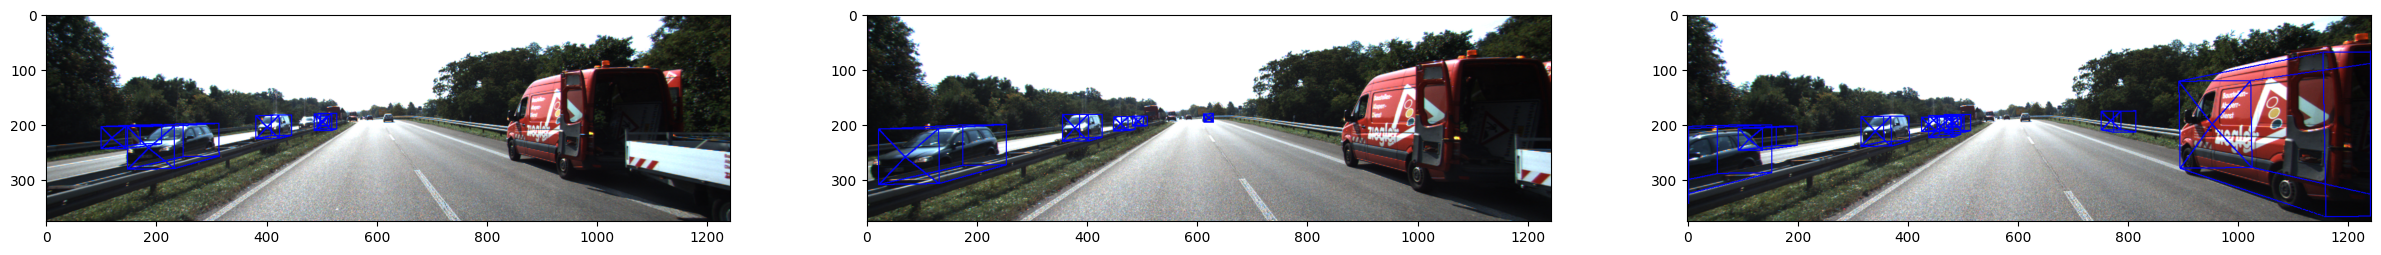

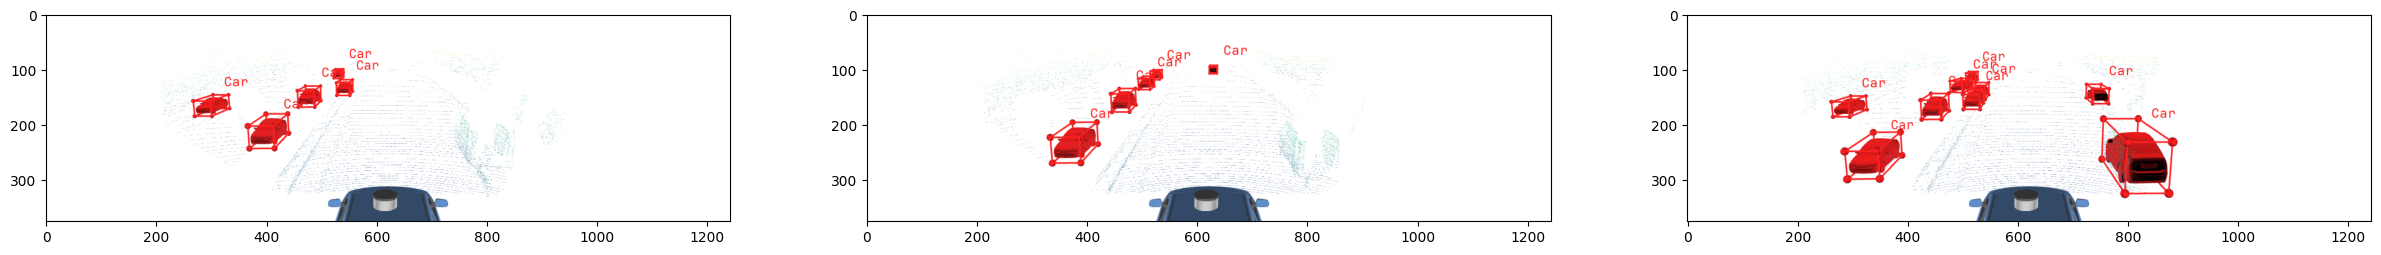

In [ ]:
images_2d = glob.glob("frames/*.png")
images_3d = glob.glob("3dframes/*.png")
view_images(sorted(images_2d))
view_images(sorted(images_3d))

In [ ]:
from vedo import *   # For some reason, this needs to be imported everytime you need to run this cell or else it wil crash. very important!
settings.default_backend = 'ipyvtk'

visualize_scene(dataset, hand_picked_frames, detection=True, interactive=True, threshold=0.7)

[vedo.io.py:1560] INFO: Saved files ./0.x3d and ./0.html
INFO:vedo:Saved files ./0.x3d and ./0.html
[vedo.io.py:1560] INFO: Saved files ./1.x3d and ./1.html
INFO:vedo:Saved files ./1.x3d and ./1.html
[vedo.io.py:1560] INFO: Saved files ./2.x3d and ./2.html
INFO:vedo:Saved files ./2.x3d and ./2.html


In [ ]:
# %show_interactive_plots

In [ ]:
from multi_object_tracking.tracker.box_op import *
import numpy as np
from multi_object_tracking.tracker.object import Object

In [ ]:
class Tracker3D:
    def __init__(self):
        self.current_timestamp = None
        self.current_pose = None
        self.current_bbs = None
        self.box_type = "Kitti" #Available box type "OpenPCDet", "Kitti", "Waymo"
        self.next_id = 0
        self.active_trajectories = {}
        self.dead_trajectories = {}

tracker = Tracker3D()

In [ ]:
LIDAR_SCANNING_FREQUENCY = 10 #In Hz
TRACKING_LATENCY = 0 #in seconds | -1 = Global | 0-500 = Online or Near-Online

In [ ]:
class Obstacle3D:
    def __init__(self,init_bb=None,init_score=None,init_timestamp=None,label=None):
        assert init_bb is not None
        self.init_bb = init_bb
        self.init_score = init_score
        self.init_timestamp = init_timestamp
        self.label = label
        self.dt = 1./LIDAR_SCANNING_FREQUENCY
        self.trajectory = {}
        self.init_kf()
        self.init_trajectory()
        self.consecutive_missed_num = 0
        self.first_updated_timestamp = init_timestamp
        self.last_updated_timestamp = init_timestamp

    def __len__(self):
        return len(self.trajectory)

    def init_kf(self):
        STATE_FUNC_COVARIANCE =  100
        MEASURE_FUNC_COVARIANCE = 0.001

        # State Transition Matrix F (with 0s)
        self.F = np.mat(np.eye(9))

        # Process Noise Q
        self.Q = np.mat(np.eye(9))*STATE_FUNC_COVARIANCE

        # Measurement Noise
        self.R = np.mat(np.eye(3))*MEASURE_FUNC_COVARIANCE

        # Mapping Matrix / Measurement Function
        self.H = np.mat(np.zeros(shape=(3,9)))
        self.H[0:3,:] = self.F[0:3,:]

        # State Transition Matrix F (filled with constant acceleration model)
        self.F[0:3,3:6] = np.mat(np.eye(3))*self.dt #Position XYZ
        self.F[3:6,6:9] = np.mat(np.eye(3))*self.dt # Velocity XYZ
        self.F[0:3,6:9] = np.mat(np.eye(3))*0.5*self.dt**2 # Acc XYZ

        # Kalman Gain
        self.K = np.mat(np.zeros(shape=(9,9)))
        self.K[3, 0] = self.dt
        self.K[4, 1] = self.dt
        self.K[5, 2] = self.dt

    def init_trajectory(self):
        # Create a new Object instance
        object = Object()

        # Initialize detected state based on the initial bounding box (init_bb)
        detected_state = np.zeros(shape=(3))
        detected_state[:3] = self.init_bb[:3]
        detected_state = np.mat(detected_state).T
        object.detected_state = detected_state

        # Set predicted and updated state to the same value
        object.predicted_state = object.updated_state = self.H.T * detected_state

        # Initialize the covariance matrices
        update_covariance = np.mat(np.eye(9) * 0.01)
        object.updated_covariance = object.predicted_covariance = update_covariance.T

        # Set prediction score and initial score
        object.prediction_score = 1
        object.score = self.init_score

        # Add the object to the trajectory dictionary with the initial timestamp as the key
        self.trajectory[self.init_timestamp] = object

In [ ]:
def state_prediction(self,timestamp):
        # Decay factor for prediction score
        PREDICTION_SCORE_DECAY = 0.03

        # Get the previous timestamp
        previous_timestamp = timestamp-1

        # Check that the previous timestamp exists in the trajectory
        assert previous_timestamp in self.trajectory.keys()

        # Get the previous object
        previous_object = self.trajectory[previous_timestamp]

        # Get the previous state and covariance
        if previous_object.updated_state is not None:
            previous_state = previous_object.updated_state
            previous_covariance = previous_object.updated_covariance
        else:
            previous_state = previous_object.predicted_state
            previous_covariance = previous_object.predicted_covariance

        # Get the previous prediction score
        previous_prediction_score = previous_object.prediction_score

        # Calculate the current prediction score based on the previous prediction score
        # and whether the previous state was updated
        if previous_timestamp in self.trajectory.keys():
            if self.trajectory[previous_timestamp].updated_state is not None:
                current_prediction_score = previous_prediction_score * (1 - PREDICTION_SCORE_DECAY*15)
            else:
                current_prediction_score = previous_prediction_score * (1 - PREDICTION_SCORE_DECAY)
        else:
            current_prediction_score = previous_prediction_score * (1 - PREDICTION_SCORE_DECAY)

        print(current_prediction_score)
        # KF Predict: Calculate the predicted state and covariance using the previous state and covariance
        current_predicted_state = self.F*previous_state
        current_predicted_covariance = self.F*previous_covariance*self.F.T + self.Q

        # Create a new object to store the predicted state, predicted covariance, and prediction score
        new_ob = Object()
        new_ob.predicted_state = current_predicted_state
        new_ob.predicted_covariance = current_predicted_covariance
        new_ob.prediction_score = current_prediction_score

        # Add the new object to the trajectory and update the consecutive missed count
        self.trajectory[timestamp] = new_ob
        self.consecutive_missed_num += 1

Obstacle3D.state_prediction = state_prediction

In [ ]:
test_score = 1
print(test_score * (1-0.03*15))
print(test_score*(1-0.03))

0.55
0.97


In [ ]:
def predict_trajectories(self):
    # Maximum allowed number of consecutive missed predictions before a trajectory is considered dead
    MAX_PREDICTION_NUM = 12

    # Minimum trajectory length required for a new object (with only one detection) to be considered dead
    MAX_PREDICTION_NUM_FOR_NEW_OBJECT = 2

    # If there are no active trajectories, return immediately
    if len(self.active_trajectories) == 0 :
        return

    else:
        # A list to store the IDs of dead trajectories
        dead_track_id = []

        # Iterate through all keys (trajectory IDs) in the active_trajectories dictionary
        for key in self.active_trajectories.keys():
            # If a trajectory has consecutive missed predictions >= MAX_PREDICTION_NUM, mark it as dead
            if self.active_trajectories[key].consecutive_missed_num>=MAX_PREDICTION_NUM:
                dead_track_id.append(key)
                continue

            # If a trajectory has only one successful detection and its length >= MAX_PREDICTION_NUM_FOR_NEW_OBJECT,
            # mark it as dead
            if len(self.active_trajectories[key])-self.active_trajectories[key].consecutive_missed_num == 1 \
                and len(self.active_trajectories[key])>= MAX_PREDICTION_NUM_FOR_NEW_OBJECT :
                dead_track_id.append(key)
                continue

            # Predict the state of the trajectory based on the current timestamp
            self.active_trajectories[key].state_prediction(self.current_timestamp)

        # Move dead trajectories from active_trajectories to dead_trajectories
        for id in dead_track_id:
            tra = self.active_trajectories.pop(id)
            self.dead_trajectories[id]=tra

Tracker3D.predict_trajectories=predict_trajectories

In [ ]:
def compute_cost_map(self):
    # Initialize empty lists to store IDs, predictions, and detections
    all_ids = []
    all_predictions = []
    all_detections = []

    # Loop over all active trajectories
    for key in self.active_trajectories.keys():
        print("New Trajectory Tested")
        # Get the ID of the trajectory
        all_ids.append(key)
        # Get the predicted state and prediction score of the trajectory at the current timestamp
        state = np.array(self.active_trajectories[key].trajectory[self.current_timestamp].predicted_state)
        print(state)
        state = state.reshape(-1)
        pred_score = np.array([self.active_trajectories[key].trajectory[self.current_timestamp].prediction_score])
        print(pred_score)
        # Concatenate the predicted state and prediction score into a single array
        state = np.concatenate([state,pred_score])
        print(state)

        # Append the array to the all_predictions list
        all_predictions.append(state)

    # Loop over all current bounding boxes and scores
    for i in range(len(self.current_bbs)):
        # Create a new trajectory object using the current bounding box, score, timestamp, and label
        box = self.current_bbs[i]
        score = self.current_scores[i]
        label=1
        new_tra = Obstacle3D(init_bb=box,
                             init_score=score,
                             init_timestamp=self.current_timestamp,
                             label=label)

        # Get the predicted state of the new trajectory at the current timestamp
        state = new_tra.trajectory[self.current_timestamp].predicted_state
        state = state.reshape(-1)

        # Append the predicted state to the all_detections list
        all_detections.append(state)

    print(all_detections)
    print(all_predictions)
    # Convert the all_detections and all_predictions lists into numpy arrays
    all_detections = np.array(all_detections)
    all_predictions = np.array(all_predictions)

    # Reshape the all_detections and all_predictions arrays to prepare for broadcasting
    det_len = len(all_detections)
    pred_len = len(all_predictions)
    all_detections = all_detections.reshape((det_len,1,-1))
    all_predictions = all_predictions.reshape((1,pred_len,-1))

    # Use np.tile to create copies of the all_detections and all_predictions arrays to prepare for broadcasting
    all_detections = np.tile(all_detections,(1,pred_len,1))
    all_predictions = np.tile(all_predictions,(det_len,1,1))

    print(all_detections)
    print(all_predictions)

    # Use broadcasting to calculate the Euclidean distance between all pairs of detections and predictions
    dis = (all_detections[...,0:3]-all_predictions[...,0:3])**2
    dis = np.sqrt(dis.sum(-1))

    # Calculate the cost for associating each detection with each prediction based on the Euclidean distance and the prediction score
    cost = dis*all_predictions[...,-1]

    # Return the cost map and the list of trajectory IDs
    return cost,all_ids

Tracker3D.compute_cost_map = compute_cost_map

In [ ]:
def association(self):
    # If there are no active trajectories, assign unique IDs to each detection
    if len(self.active_trajectories) == 0:
        ids = []
        for i in range(len(self.current_bbs)):
            ids.append(self.next_id)
            self.next_id+=1
        return ids

    # If there are active trajectories, use the cost map to assign IDs to each detection
    else:
        ids = []

        # Compute the cost map
        cost_map, all_ids = self.compute_cost_map()

        print(cost_map)
        # Loop over all current bounding boxes
        for i in range(len(self.current_bbs)):

            # Find the index of the minimum cost for the current detection
            min = np.min(cost_map[i])
            arg_min = np.argmin(cost_map[i])

            # If the minimum cost is below a certain threshold, assign the ID of the corresponding active trajectory
            if min<2.:
                ids.append(all_ids[arg_min])

                # Set the cost for the corresponding active trajectory to a very high value to prevent it from being assigned again
                cost_map[:,arg_min] = 100000

            # If the minimum cost is above the threshold, assign a new ID (new object)
            else:
                ids.append(self.next_id)
                self.next_id+=1
        return ids

Tracker3D.association=association

In [ ]:
def sigmoid(self,x):
    return 1.0/(1+np.exp(-float(x)))

def state_update(self,bb=None,score=None,timestamp=None,):
    assert bb is not None
    assert timestamp in self.trajectory.keys()

    # Set the prediction score decay rate
    PREDICTION_SCORE_DECAY = 0.03

    # Create a template for the detected state using the bounding box coordinates
    detected_state = np.zeros(shape=(3))
    detected_state[:3] = bb[:3] #init x,y,z
    detected_state = np.mat(detected_state).T

    # Get the predicted state and covariance at the current timestamp
    current_ob = self.trajectory[timestamp]
    predicted_state = current_ob.predicted_state
    predicted_covariance = current_ob.predicted_covariance

    # Calculate the Kalman gain and update the state and covariance based on the detected state
    y = detected_state - self.H*predicted_state
    S = self.H*predicted_covariance*self.H.T+self.R
    KF_gain = predicted_covariance*self.H.T*S.I

    updated_state = predicted_state+KF_gain*y
    updated_covariance = (np.mat(np.eye(9)) - KF_gain*self.H)*predicted_covariance

    # If there are two consecutive timestamps with detected states, use the velocity to update the state
    if len(self.trajectory)==2:
        updated_state = self.H.T*detected_state+\
                        self.K*(self.H.T*detected_state-self.trajectory[timestamp-1].updated_state)

    # Update the trajectory object with the new state, covariance, detected state, and prediction score
    current_ob.updated_state = updated_state
    current_ob.updated_covariance = updated_covariance
    current_ob.detected_state = detected_state

    # Update the prediction score based on the detected score and the decay rate
    if self.consecutive_missed_num>1:
        current_ob.prediction_score = 1
    elif self.trajectory[timestamp - 1].updated_state is not None:
        current_ob.prediction_score = current_ob.prediction_score + PREDICTION_SCORE_DECAY*10*(self.sigmoid(score))
    else:
        current_ob.prediction_score = current_ob.prediction_score + PREDICTION_SCORE_DECAY*(self.sigmoid(score))
    current_ob.score = score
    print(current_ob.prediction_score)

    # Reset the consecutive missed detection counter and update the last updated timestamp
    self.consecutive_missed_num = 0
    self.last_updated_timestamp = timestamp

Obstacle3D.state_update = state_update
Obstacle3D.sigmoid = sigmoid

In [ ]:
def update_trajectories(self,ids):
    # Set the score thresholds for initializing and updating trajectories
    INIT_SCORE = 0
    UPDATE_SCORE = 0

    # Ensure that the number of IDs matches the number of bounding boxes
    assert len(ids) == len(self.current_bbs)

    valid_bbs = []
    valid_ids = []

    # Loop over all bounding boxes and assigned IDs
    for i in range(len(self.current_bbs)):
        label = ids[i]
        box = self.current_bbs[i]
        score = self.current_scores[i]

        # If the assigned ID corresponds to an existing active trajectory and the score is above the update threshold, update the trajectory
        if label in self.active_trajectories.keys() and score>UPDATE_SCORE:
            track = self.active_trajectories[label]
            track.state_update(bb=box,score=score,timestamp=self.current_timestamp)
            valid_bbs.append(box)
            valid_ids.append(label)

        # If the score is above the initialization threshold, create a new trajectory with the assigned ID
        elif score>INIT_SCORE:
            new_tra = Obstacle3D(init_bb=box,
                                init_score=score,
                                init_timestamp=self.current_timestamp,
                                label=label)

            self.active_trajectories[label] = new_tra
            valid_bbs.append(box)
            valid_ids.append(label)

        # If the score is below both thresholds, ignore the bounding box
        else:
            continue

    # If no valid bounding boxes were found, return empty arrays
    if len(valid_bbs)==0:
        return np.zeros(shape=(0,7)),np.zeros(shape=(0))

    # Otherwise, return the valid bounding boxes and IDs as numpy arrays
    else:
        return np.array(valid_bbs),np.array(valid_ids)

Tracker3D.update_trajectories=update_trajectories

In [ ]:
def init_all():
    Tracker3D.predict_trajectories = predict_trajectories
    Tracker3D.compute_cost_map = compute_cost_map
    Tracker3D.association = association
    Tracker3D.update_trajectories = update_trajectories
    Obstacle3D.state_prediction = state_prediction
    Obstacle3D.state_update = state_update

In [ ]:
#hand_picked_frames = [0,1,2]
hand_picked_frames = range(30,35)
print(hand_picked_frames)

range(30, 35)


In [ ]:
tracker=Tracker3D()
init_all()

In [ ]:
all_time = 0
frame_num = 0

final_bbs = []
final_ids = []

for i in hand_picked_frames:
    # Run Object Detection and postprocessing
    #P2, V2C, points, image, objects, scores = dataset[i]
    P2, V2C, points, image, objects, scores, label_names, pose = dataset[i] # for detection, labels -> objects detected; label_names -> detection scores
    #frame_id, pose, P2, V2C, points, image, objects, scores, label_names = dataset[i].values()

    mask = scores>0.8
    objects = objects[mask]
    scores = scores[mask]
    # Initialize the Tracker
    start = time.time()
    tracker.current_bbs = objects[:,:7]
    tracker.current_scores = scores
    tracker.current_pose = pose
    tracker.current_timestamp = i

    # Kalman Filter: Predict
    tracker.predict_trajectories()
    if tracker.current_bbs is None:
        final_bbs.append(np.zeros(shape=(0,7)))
        final_ids.append(np.zeros(shape=(0)))
    else:
        if len(tracker.current_bbs) ==0:
            final_bbs.append(np.zeros(shape=(0,7)))
            final_ids.append(np.zeros(shape=(0)))
    # If Boxes, Associate them with t-1 & Kalman Filter: Update
        else:
            #if(tracker.current_bbs is not None) or (len(tracker.current_bbs) >0):
            tracker.current_bbs = convert_bbs_type(tracker.current_bbs,tracker.box_type) # For KITTI only
            tracker.current_bbs = register_bbs(tracker.current_bbs,tracker.current_pose)
            ids = tracker.association()
            bbs,ids = tracker.update_trajectories(ids)

            final_bbs.append(bbs)
            final_ids.append(ids.tolist())

    # Print or Visualize Output
    #print(np.array(bbs))
    #print(np.array(ids))

    end = time.time()
    all_time+=end-start
    frame_num+=1

0.55
0.55
New Trajectory Tested
[[98.15978608]
 [ 6.85583665]
 [-0.55050929]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
[0.55]
[98.15978608  6.85583665 -0.55050929  0.          0.          0.
  0.          0.          0.          0.55      ]
New Trajectory Tested
[[119.70100222]
 [ 21.53567373]
 [ -1.09128212]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]]
[0.55]
[119.70100222  21.53567373  -1.09128212   0.           0.
   0.           0.           0.           0.           0.55      ]
[matrix([[98.16874239,  6.81451996, -0.52366135,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ]])]
[array([98.15978608,  6.85583665, -0.55050929,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.55      ]), array([119.70100222,  21.53567373,  -1.09128212,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,

The new directory 'frames' is created!
The new directory 3dframes is created!


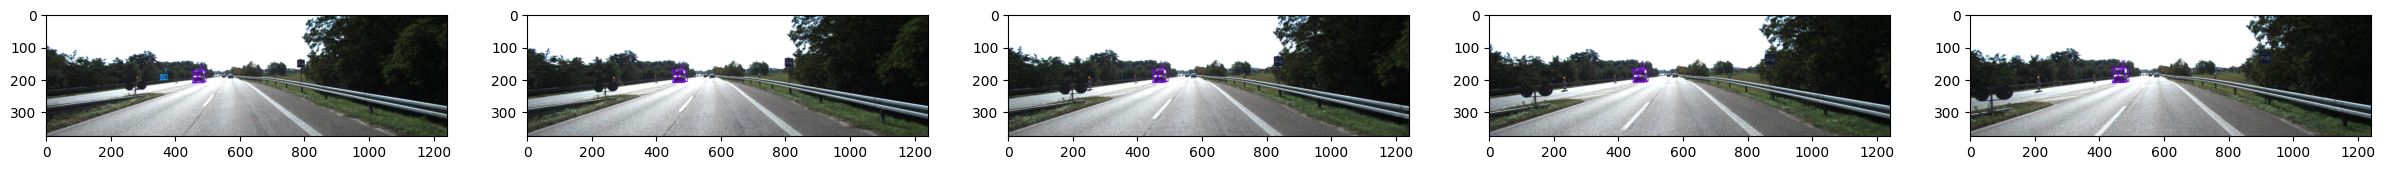

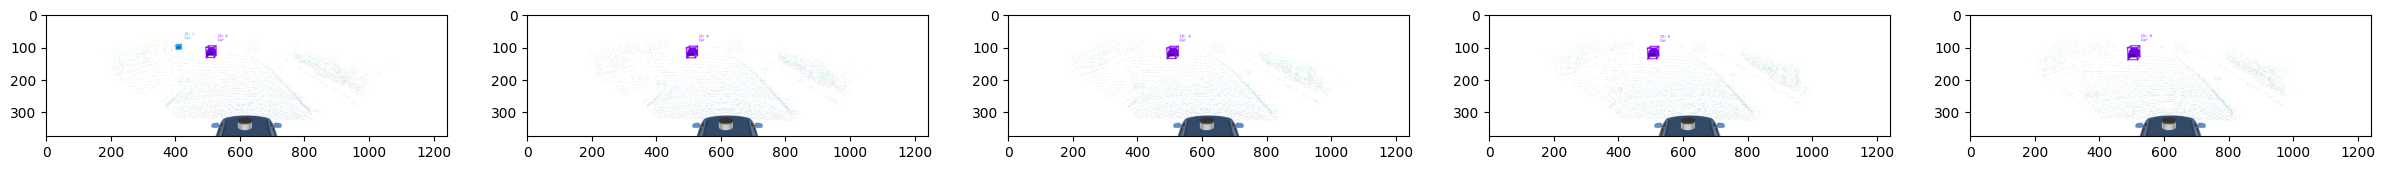

In [ ]:
shutil.rmtree('frames', ignore_errors=True)
shutil.rmtree("3dframes", ignore_errors= True)

### Just visualize Raw Data
settings.default_backend = '2d_image'
settings.default_image_path_for_2d_backend = '3dframes'

visualize_scene(dataset, hand_picked_frames, detection=True, tracking=final_ids, threshold=0.8)

images_2d = glob.glob("frames/*.png")
images_3d = glob.glob("3dframes/*.png")
view_images(sorted(images_2d))
view_images(sorted(images_3d))

In [ ]:
from vedo import *   # For some reason, this needs to be imported everytime you need to run this cell or else it wil crash. very important!
settings.default_backend = 'ipyvtk'

visualize_scene(dataset, hand_picked_frames, detection=True, tracking=final_ids, interactive=True, threshold=0.8)
# %show_interactive_plots

ModuleNotFoundError: No module named 'vedo'

In [ ]:
len(dataset)

390

In [ ]:
hand_picked_frames = range(len(dataset))

In [ ]:
# hand_picked_frames=range(75)

In [ ]:
def generate_video(globInputPath,  outvideoFileName):

    video_images = sorted(glob.glob(globInputPath))

    result_video = []
    idx = 0
    stored_obstacles = []

    for out_im in tqdm(video_images):
        out_img_dat = cv2.cvtColor(cv2.imread(out_im), cv2.COLOR_BGR2RGB)
        result_video.append(out_img_dat)

    out = cv2.VideoWriter(outvideoFileName ,cv2.VideoWriter_fourcc(*'MP4V'), 15, (out_img_dat.shape[1],out_img_dat.shape[0]))

    for img in result_video:
      out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    out.release()
    print("Output file name " + outvideoFileName + " generated")


In [ ]:
_2d_mot_to_view = '2d_mot.mp4'
_3d_mot_to_view = '3d_mot.mp4'

generate_video("/content/drive/MyDrive/pro2024/frames/*.png", _2d_mot_to_view) #2d
generate_video("/content/drive/MyDrive/pro2024/3dframes/*.png", _3d_mot_to_view) #3d

100%|██████████| 10/10 [00:00<00:00, 42.28it/s]


Output file name 2d_mot.mp4 generated


100%|██████████| 5/5 [00:00<00:00, 84.35it/s]

Output file name 3d_mot.mp4 generated


In [ ]:
pwd

'/content/drive/MyDrive/pro2024'

In [ ]:
import cv2
import numpy as np

def merge_videos(videos_to_merge, output_video_path, grid_size, titles, title_position=(0.5, 0.5), max_frames=None):
    # Open video capture objects
    video_captures = [cv2.VideoCapture(video) for video in videos_to_merge]

    # Get frame dimensions from the first video
    frame_width = int(video_captures[0].get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_captures[0].get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(video_captures[0].get(cv2.CAP_PROP_FPS))

    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width * grid_size[1], frame_height * grid_size[0]))

    # Determine the number of frames to process
    if max_frames is None:
        max_frames = min(int(video_captures[0].get(cv2.CAP_PROP_FRAME_COUNT)), *[int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) for cap in video_captures[1:]])

    # Iterate over frames
    for _ in range(max_frames):
        # Read frames from each video capture
        frames = [cap.read()[1] for cap in video_captures]

        # Resize frames if necessary
        frames = [cv2.resize(frame, (frame_width, frame_height)) for frame in frames]

        # Create grid image
        grid_image = create_grid_image(frames, grid_size, titles, title_position)

        # Write frame to output video
        out.write(grid_image)

    # Release video capture objects and writer
    for cap in video_captures:
        cap.release()
    out.release()

def create_grid_image(frames, grid_size, titles, title_position):
    # Add titles to frames
    for i, title in enumerate(titles):
        cv2.putText(frames[i], title, (int(frames[i].shape[1] * title_position[0]), int(frames[i].shape[0] * title_position[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Create grid image
    grid_image = np.zeros((frames[0].shape[0] * grid_size[0], frames[0].shape[1] * grid_size[1], 3), dtype=np.uint8)

    # Populate grid image with frames
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            index = i * grid_size[1] + j
            if index < len(frames):
                grid_image[i * frames[0].shape[0]:(i + 1) * frames[0].shape[0], j * frames[0].shape[1]:(j + 1) * frames[0].shape[1]] = frames[index]

    return grid_image

_2d_mot_to_view = '2d_mot.mp4'
_3d_mot_to_view = '3d_mot.mp4'
_merged_mot_to_view = 'merged_mot_to_view.mp4'

videos_to_merge = [_2d_mot_to_view, _3d_mot_to_view]
titles = ['3D MOT (Image)', '3D MOT (LiDAR)']

merge_videos(videos_to_merge, _merged_mot_to_view, grid_size=(2, 1), titles=titles, title_position=(0.1, 0.1))
